# Unstructured Data Analytics HW2

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [1]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [2]:
########################################################################
######################### Write your code here #########################
########################################################################
import os

processed_doc = []
for filename in os.listdir("./data/enron"):
    processed_doc.append(make_word_list("./data/enron/" + filename))


### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [3]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=50,stop_words="english",max_df=0.8)

X = vectorizer.fit_transform(processed_doc)
vocabulary = vectorizer.vocabulary_
print("Number of unique words in the vocabulary:" + str(len(vocabulary)))

Number of unique words in the vocabulary:1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [4]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.mixture import GaussianMixture
from collections import Counter
import numpy as np

gmm = GaussianMixture(n_components=3, random_state=0)
X_array = X.toarray()
gmm.fit(X_array)
gmm_cluster_assignments = gmm.predict(X_array)
cluster_size = Counter(gmm_cluster_assignments)

for cluster,number in cluster_size.items():
    print("Cluster "+str(cluster)+": "+str(number))    

Cluster 0: 363
Cluster 1: 1875
Cluster 2: 2933


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [17]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

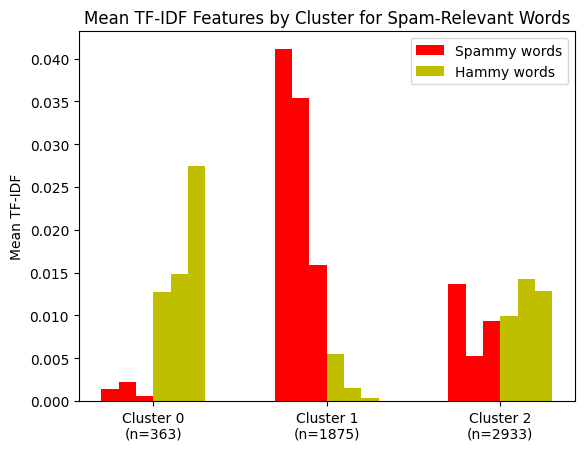

In [18]:
########################################################################
######################### Write your code here #########################
########################################################################
spammy_words = ['click','www','offer']
hammy_words = ['meeting','attached','review']

spam_indices = [vocabulary[spammy] for spammy in spammy_words]
ham_indices = [vocabulary[hammy] for hammy in hammy_words]

plot_spam_words_by_cluster(X_array,gmm_cluster_assignments,len(set(gmm_cluster_assignments)),spam_indices,ham_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

Based on the frequency of spammy and hammy words, cluster 0 corresponds to typical business (ham) emails while cluster 1 corresponds to spam emails. This is because in cluster 0, the mean TF-IDF is higher for hammy words and in cluster 1, the mean TF-IDF is higher for spammy words.

Re-running analysis with n_clusters = 5, generally the performance of locating clusters of spam emails appears better. Spammy words in cluster 2 have very high mean TF-IDF values and in cluster 3, the ratio of spammy words TF-IDF features to hammy words TF-IDF features is also higher than the spammy cluster (Cluster1) when n_cluster = 3. More emails that can not be categorized in 3-cluster GMM are correctly identified.


Cluster 0: 1159
Cluster 1: 461
Cluster 2: 265
Cluster 3: 2961
Cluster 4: 325


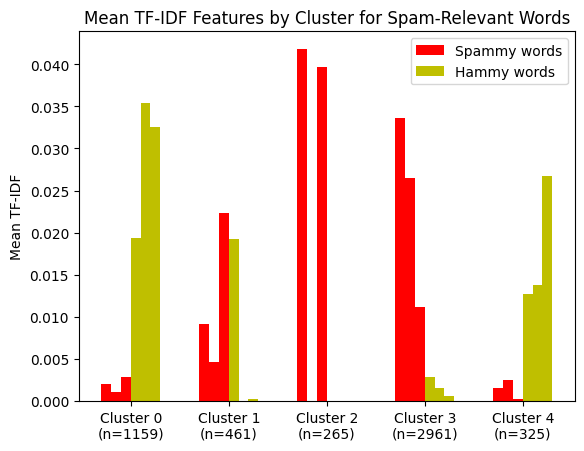

In [19]:
########################################################################
######################### Write your code here #########################
########################################################################

gmm_new = GaussianMixture(n_components=5, random_state=0)
gmm_new.fit(X_array)
gmm_new_cluster_assignments = gmm_new.predict(X_array)
new_cluster_size = Counter(gmm_new_cluster_assignments)
sorted_new_cluster_size = sorted(new_cluster_size.items(),key=lambda x:x[0])

for cluster,number in sorted_new_cluster_size:
    print("Cluster "+str(cluster)+": "+str(number))

plot_spam_words_by_cluster(X_array,gmm_new_cluster_assignments,len(set(gmm_new_cluster_assignments)),spam_indices,ham_indices)

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [21]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [22]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [23]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [24]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [25]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfTransformer

transformer_app = TfidfTransformer()
X = transformer_app.fit_transform(X)


### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [26]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.decomposition import LatentDirichletAllocation
num_topics = 10

lda = LatentDirichletAllocation(n_components=num_topics, max_iter =10, n_jobs=-1, random_state=0)
lda.fit(X)


Wall time: 1min 14s


LatentDirichletAllocation(n_jobs=-1, random_state=0)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:
  

In [29]:
########################################################################
######################### Write your code here #########################
########################################################################
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(10):
        word_idx = sort_indices[rank]
        print(permission_columns[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

[Topic 0]
Your location : coarse (network-based) location (D) : 0.255334981898809
Your location : fine (GPS) location (D) : 0.24579947092592744
Network communication : full Internet access (D) : 0.15369908539947516
Network communication : view network state (S) : 0.1024427669284403
Phone calls : read phone state and identity (D) : 0.0824894583294347
Storage : modify/delete USB storage contents modify/delete SD card contents (D) : 0.0656106296956535
Services that cost you money : directly call phone numbers (D) : 0.05300317397110292
Network communication : view Wi-Fi state (S) : 0.026017328104751134
Your personal information : read sensitive log data (D) : 0.014709118782127098
Hardware controls : control vibrator (S) : 0.00022023272559928048

[Topic 1]
Hardware controls : control vibrator (S) : 0.5152112147764315
Network communication : full Internet access (D) : 0.15154252184472775
Network communication : view network state (S) : 0.10055381830165719
Phone calls : read phone state and i

   * Topic 3: This topic might be related to apps checking identification and security.
   
   Its top permissions are 1. discover known accounts, 2. use the authentication credentials of an account, 3. prevent device from sleeping, 4. read sensitive log data, 5. modify/delete USB storage contents modify/delete SD card contents. These app purposes are to check account information, get sensitive data and make credentials verification. 
   
  
  
  * Topic 6: This topic might be related to social apps that allow users to interact with contacts. 
   
   Its top permissions are 1. take pictures and videos, 2. record audio, 3. modify/delete USB storage contents modify/delete SD card contents, 4. fine location, 5. Internet access. For example, Wechat / Instagram allow users to take photos or create videos with audio and send them to their contacts. And users can save these files received from others into their phones. Also, users can share their real time position with friends and locate users nearby.
   
   
  * Topic 9: This topic might be related to instant message sending app features.
  
  Its top permissions are 1. read contact data, 2. send SMS messages, 3. discover known accounts, 4. modify global system settings, 5. read phone state and identity. These apps need functions to send and receive SMS, and also should have access to contact information.  
   
   

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [28]:
########################################################################
######################### Write your code here #########################
########################################################################
filtered_app = X[app_ratings>=100000]
filtered_app_name = np.array(app_names)[app_ratings>=100000]
doc_topic_matrix = lda.transform(filtered_app)

for topic in range(10):
    print('[Topic ', topic, ']', sep='')
    sorted_app_ind = np.argsort(-doc_topic_matrix[:,topic])[:3]
    for rank,ind in enumerate(sorted_app_ind):
        print(rank+1,".",filtered_app_name[ind],":",doc_topic_matrix[ind,topic])
    print()



[Topic 0]
1 . Dictionary.com : 0.7169202126395239
2 . Air Control Lite : 0.7169202126395239
3 . Paper Toss : 0.6935370713374321

[Topic 1]
1 . Bubble Blast 2 : 0.6932429431507394
2 . Drag Racing : 0.6932429431507394
3 . Mouse Trap : 0.6932429431507394

[Topic 2]
1 . Angry Birds Seasons : 0.6247322716989121
2 . Yoo Ninja! Free : 0.6247322716989121
3 . Adobe Reader : 0.5499685248904161

[Topic 3]
1 . Lookout Security & Antivirus : 0.8569331400016756
2 . Antivirus Free : 0.8544647080761317
3 . Skype : 0.848909654070122

[Topic 4]
1 . Real BlackJack : 0.7163516110332171
2 . Alchemy : 0.7154549420796851
3 . Tank Hero : 0.7153276104408395

[Topic 5]
1 . World Newspapers : 0.696199359923326
2 . My Country : 0.696199359923326
3 . Paradise Island : 0.696199359923326

[Topic 6]
1 . Brightest Flashlight Free™ : 0.7624637869589526
2 . Brightest Flashlight Free??? : 0.7624637869589526
3 . Tiny Flashlight + LED : 0.7496709408477027

[Topic 7]
1 . Slice It! : 0.7208886345801729
2 . Racing Moto : 0.68

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1001 samples in 0.008s...
[t-SNE] Computed neighbors for 1001 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1001
[t-SNE] Computed conditional probabilities for sample 1001 / 1001
[t-SNE] Mean sigma: 0.000000


D:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.160000
[t-SNE] KL divergence after 1000 iterations: -1.086503


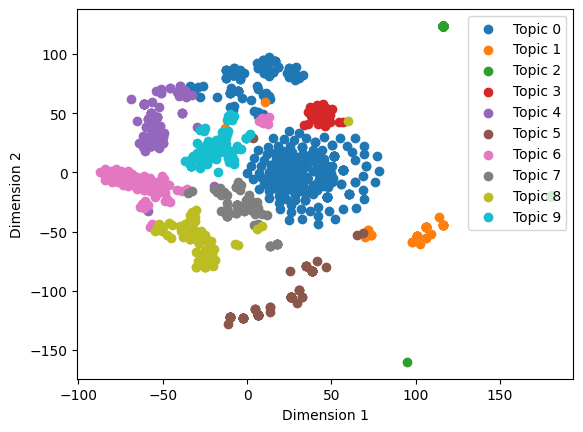

Wall time: 8.94 s


In [16]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.manifold import TSNE
doc_topic_proportion_matrix = lda.transform(X)

num_samples = X.shape[0]
random_sample = np.random.permutation(num_samples)[:1001]

tsne = TSNE(n_components=2, angle = 0.99, init = 'pca', verbose=1,learning_rate =200, random_state=0)
feature_vectors_tsne2d = tsne.fit_transform(doc_topic_proportion_matrix[random_sample])
topic_labels = np.argmax(doc_topic_proportion_matrix[random_sample],axis=1)

for label in set(topic_labels):
    plt.scatter(feature_vectors_tsne2d[:, 0][topic_labels==label], feature_vectors_tsne2d[:, 1][topic_labels==label],
            label=('Topic ' + str(label)))
plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
    

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://forms.gle/vXbmEehDByuxtgCG9